# Model training, testing and selection

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb


In [58]:
data = pd.read_csv('../data/cleaned_data.csv')

In [59]:
X = data.drop('price', axis=1)
y = data['price']

X_work, X_test, y_work, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_work, y_work, test_size=0.2 ,random_state=42)

In [60]:
def safe_mape(y_true, y_pred, epsilon=1e-10):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    non_zero_idx = np.abs(y_true) > epsilon
    if not np.any(non_zero_idx):
        return np.nan  # or some fallback value
    return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100


In [61]:
def evaluate_model(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        results[name] = {
            'R2': r2_score(y_test, y_pred),
            'MSE': mean_squared_error(y_test, y_pred),
            'RMSE': root_mean_squared_error(y_test, y_pred),
            'MAE': mean_absolute_error(y_test, y_pred),
            'MAPE': safe_mape(y_test, y_pred)
        }
    return pd.DataFrame(results).T.sort_values(by='R2', ascending=False)


In [62]:

def visualize_results(results_df):
    """
    Visualizes evaluation metrics of models using individual bar plots per metric.
    """
    # Set plot style
    sns.set(style="whitegrid")

    # Reshape results for plotting
    results_melted = results_df.reset_index().melt(id_vars='index', 
                                                   var_name='Metric', 
                                                   value_name='Value')
    results_melted.rename(columns={'index': 'Model'}, inplace=True)

    # Plot each metric separately
    unique_metrics = results_melted['Metric'].unique()
    for metric in unique_metrics:
        metric_data = results_melted[results_melted['Metric'] == metric]

        plt.figure(figsize=(10, 5))
        sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')
        plt.title(f'{metric} by Model')
        plt.ylabel(metric)
        plt.xlabel('Model')
        plt.xticks(rotation=45)

        # Annotate values on bars
        for i, row in metric_data.iterrows():
            plt.text(i % len(metric_data['Model'].unique()), row['Value'], 
                     f"{row['Value']:.2f}", ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()


In [63]:
def plot_predictions(models, X_test, y_test):
    """
    Generate scatter plots of actual vs. predicted values for each model.
    """
    n_models = len(models)
    n_cols = 2
    n_rows = int(np.ceil(n_models / n_cols))

    plt.figure(figsize=(6 * n_cols, 4.5 * n_rows))
    sns.set(style="whitegrid")

    for idx, (name, model) in enumerate(models.items(), 1):
        y_pred = model.predict(X_test)

        plt.subplot(n_rows, n_cols, idx)
        sns.scatterplot(x=y_test, y=y_pred, color='royalblue', alpha=0.6, s=40)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')  # perfect fit line
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"{name} - Actual vs Predicted")
        plt.tight_layout()

    plt.suptitle("Scatter Plots: Actual vs Predicted", fontsize=16, y=1.02)
    plt.show()

## 1. Round 1 - Initial model comparisson

In [64]:
LR = LinearRegression()
DT = DecisionTreeRegressor(random_state=42)
RF = RandomForestRegressor(random_state=42)
SVR = SVR()
KNN = KNeighborsRegressor()
XGB = xgb.XGBRegressor(random_state=42)

LR.fit(X_train, y_train)
DT.fit(X_train, y_train)    
RF.fit(X_train, y_train)
SVR.fit(X_train, y_train)
KNN.fit(X_train, y_train)
XGB.fit(X_train, y_train)

models = {
    'Linear Regression': LR,
    'Decision Tree': DT,
    'Random Forest': RF,
    'Support Vector Regression': SVR,
    'K-Nearest Neighbors': KNN,
    'XGBoost': XGB
}

results = evaluate_model(models, X_test, y_test)
results

,R2,MSE,RMSE,MAE,MAPE
Linear Regression,0.608461,5.970915e+10,244354.559328,136212.931610,25.810055
XGBoost,0.591038,6.236605e+10,249731.959200,116622.005083,20.096050
Random Forest,0.588351,6.277589e+10,250551.174355,116065.394497,20.424361
K-Nearest Neighbors,0.557312,6.750919e+10,259825.303042,118683.257265,20.836936
Decision Tree,0.179970,1.250533e+11,353628.720264,164784.774271,28.570741
Support Vector Regression,-0.056743,1.611517e+11,401437.023286,238210.567218,44.220622


C:\Users\david\AppData\Local\Temp\ipykernel_15576\88830052.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


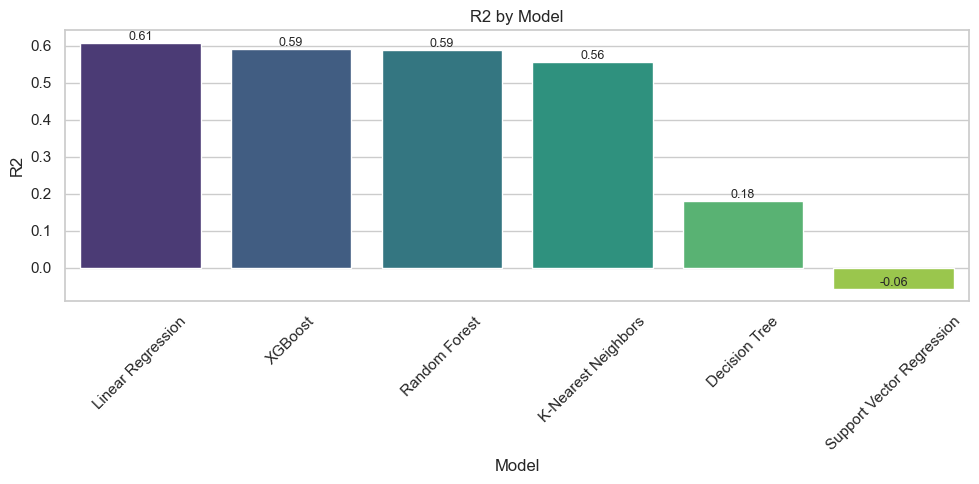

C:\Users\david\AppData\Local\Temp\ipykernel_15576\88830052.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


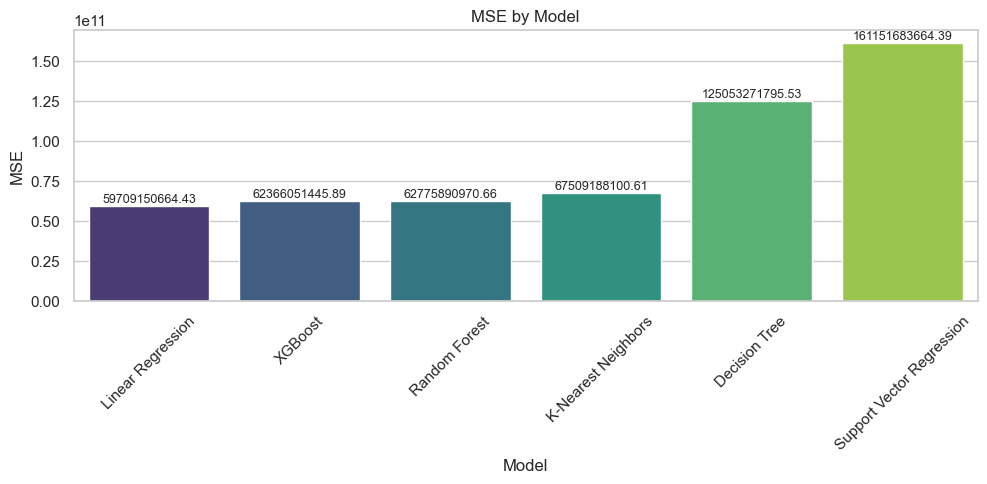

C:\Users\david\AppData\Local\Temp\ipykernel_15576\88830052.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


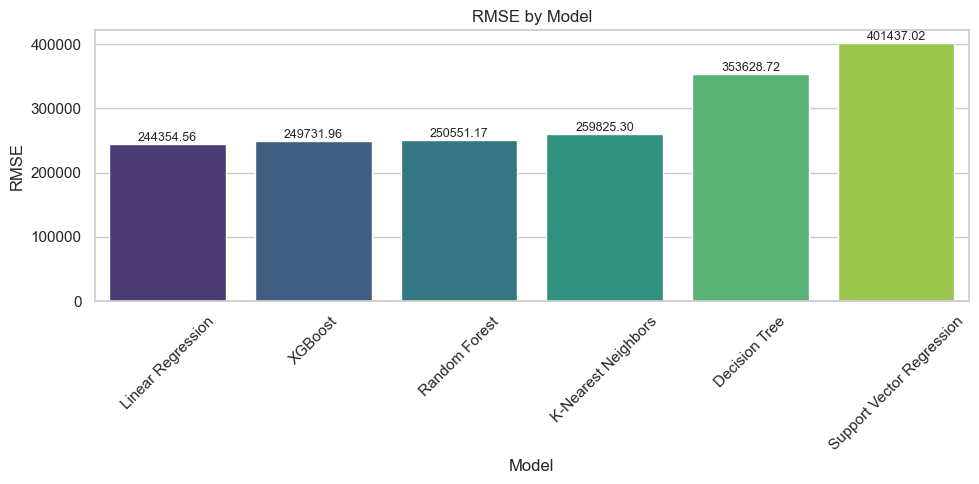

C:\Users\david\AppData\Local\Temp\ipykernel_15576\88830052.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


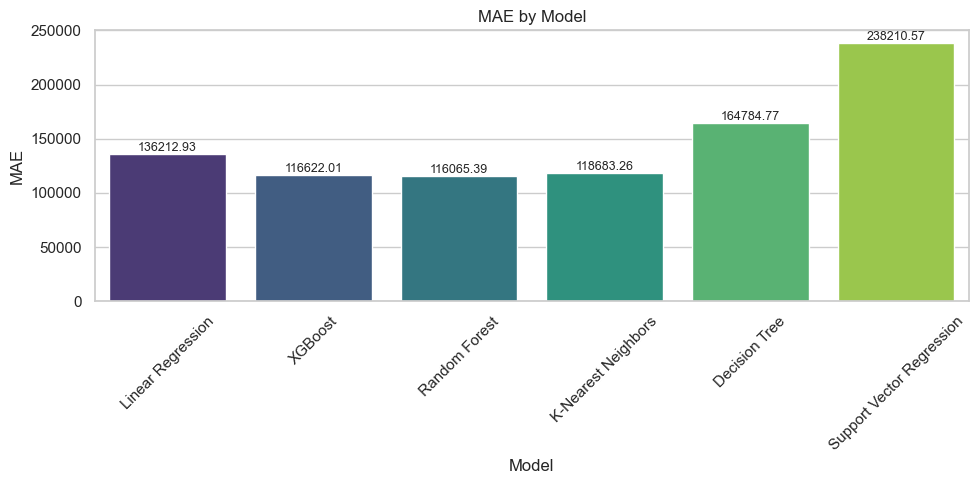

C:\Users\david\AppData\Local\Temp\ipykernel_15576\88830052.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metric_data, x='Model', y='Value', palette='viridis')


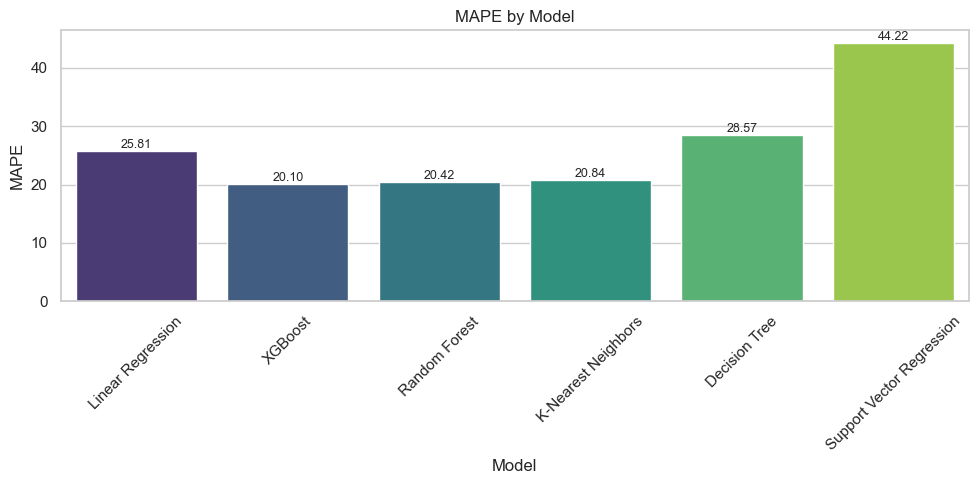

In [65]:
visualize_results(results)

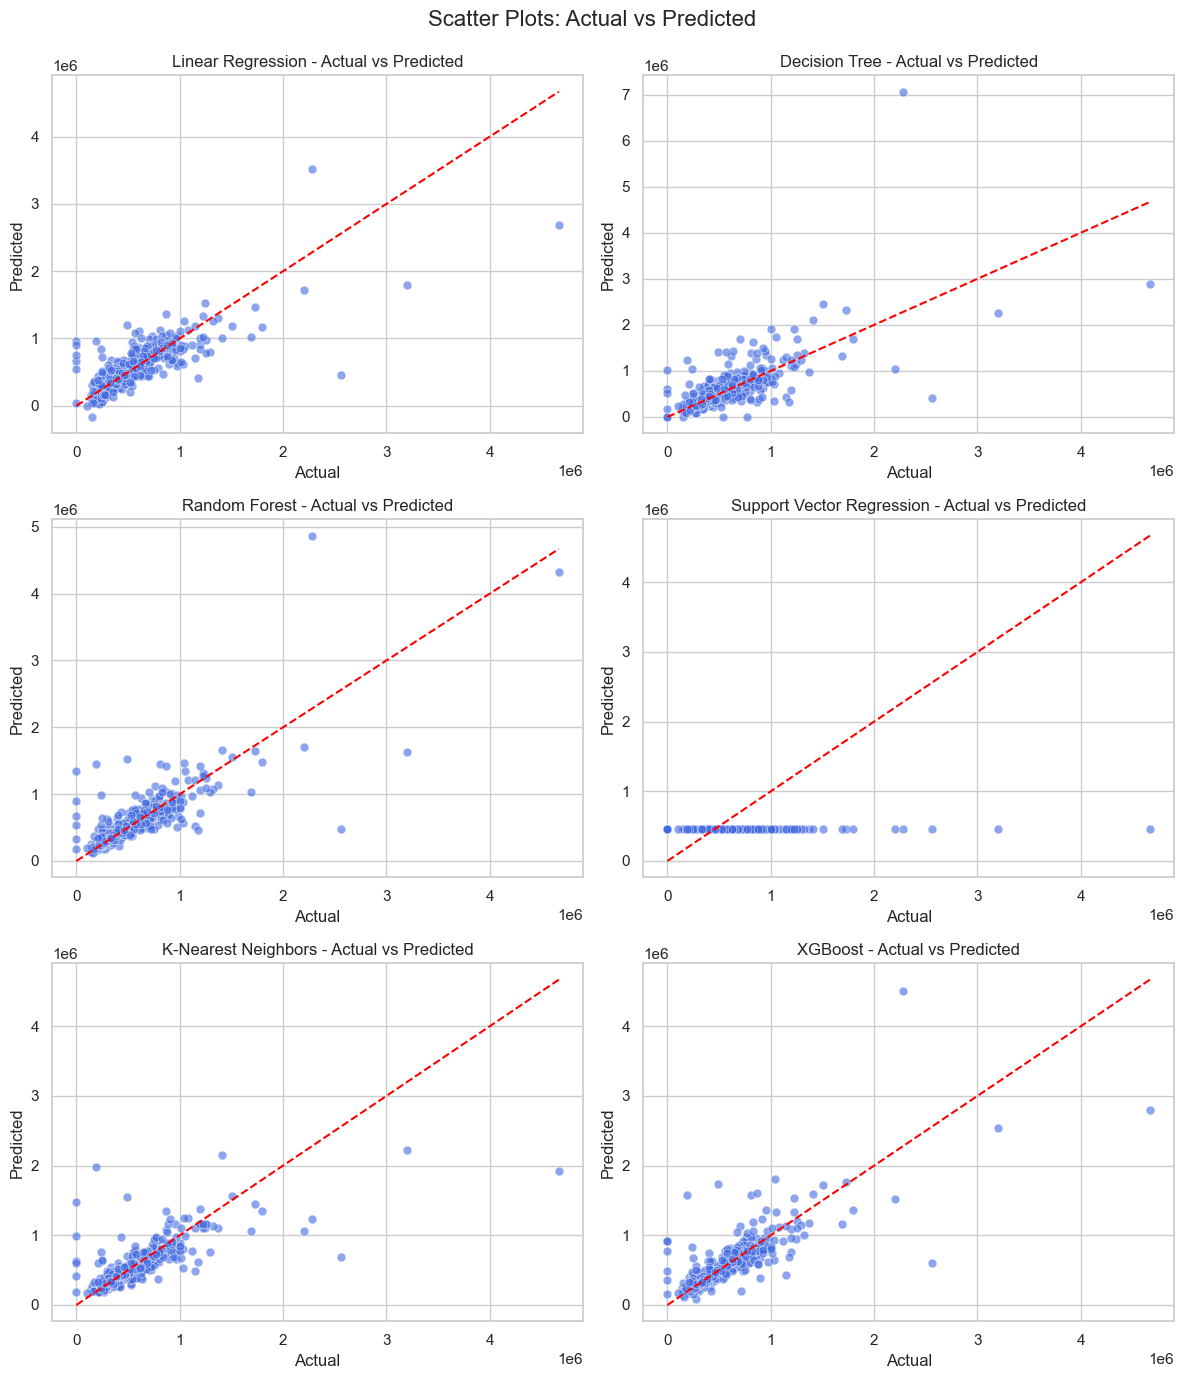

In [66]:
plot_predictions(models, X_test, y_test)

## 2. Round 2 - Hyperparameter optimization

## 3. Round 3 - 

## 4. Model Testing and final thoughts